In [2]:
import pickle
import pandas as pd
from CITEsort.BTreeTraversal import BTreeTraversal
from CITEsort.Visualize import plot_keymarker,visualize_tree
import matplotlib
#import numpy as np
from matplotlib import pyplot as plt

## load data and tree 

In [33]:
data = pd.read_csv('../simulator/ADT_simulator_11_3.csv',header=0,index_col=0)
# data = pd.read_csv('../data/seurat_v3/adt_main_clr_1.csv',header=0,index_col=0)

f = open('CITEsort_out/simulator_11_3_smooth/tree.pickle','rb')
# f = open('CITEsort_out/SeuratV3_main_ct_smooth2/tree.pickle','rb')
tree = pickle.load(f)
f.close()

In [34]:
traversal = BTreeTraversal(tree)

## plot compact tree or complete tree
#### The paramter '--compact' of runing runCITEsort.py will set the tree in compact format. If complete format is needed, plot tree again as below. The filename should no longer be 'tree', or the original tree.pdf will be overwritten.

In [12]:
visualize_tree(tree,data,outpath='./CITEsort_out',filename='tree_complete',compact=False)

/mnt/e/phd_research/cite-sort2/CITE-sort-master


## visualize all markers in a certain node
#### the node ID is just the number before the node name in tree.pdf

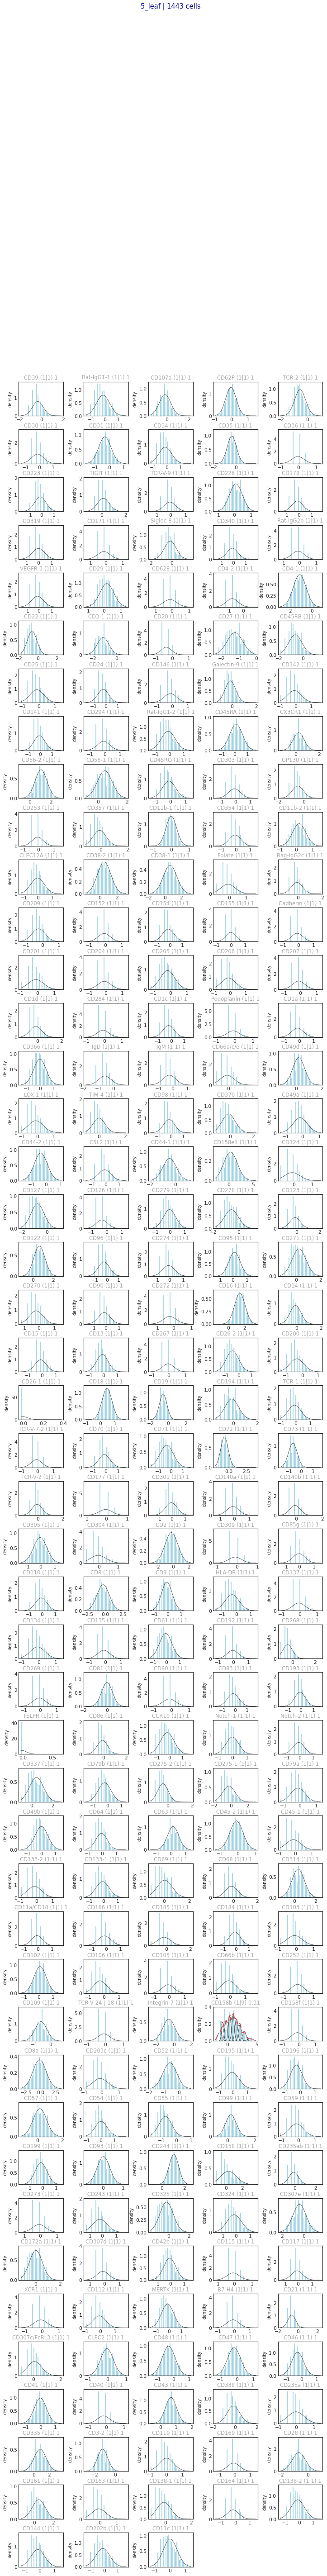

In [35]:
node_ID = 5
traversal.plot_node(data,node_ID,viz_dim=1)

In [37]:
node = traversal.get_node(5)
node.val_cnt[node.val_cnt>100]

CD62P      131.0
CD35       103.0
CD4-1      261.0
CD56-2     103.0
CD38-2     172.0
CD38-1     264.0
CD158e1    245.0
CD16       336.0
CD18       190.0
CD2        151.0
CD45-2     151.0
CD102      103.0
CD158b     214.0
CD8a       441.0
CD57       104.0
CD93       131.0
CD244      165.0
CD48       208.0
CD47       106.0
CD43       235.0
dtype: float64

In [39]:
import diptest
diptest.dipstat(data.loc[node.indices,'CD8a'])
# len(data.loc[node.indices,'CD158'])

0.008844678946540079

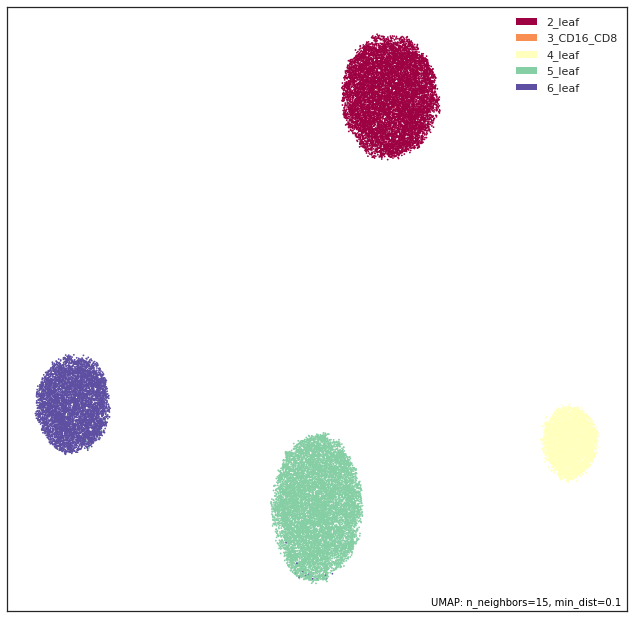

In [15]:
traversal.plot_node_umap(data, nodeID=6)

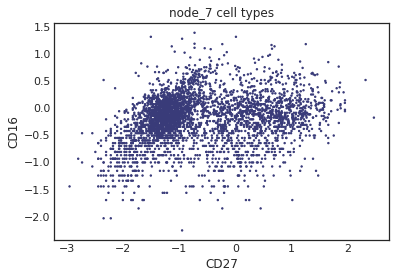

In [18]:
traversal.plot_node_2dim_new(data, 7, 'CD27', 'CD16')
# traversal.plot_node_2dim_new(data, 20, 'CD8a', 'CD4')
# traversal.plot_node_2dim_new(data, 2, 'CD4-1', 'CD19')

In [12]:
score_ll = traversal.get_ll(12)
print('likelyhood gain:')
for key,value in score_ll.items():
    print(key,round(value,3))

likelyhood gain:
('CD161',) 1.242
('CD56',) 0.331


## visualize the key marker in a certain node
#### the node ID is just the number before the node name in tree.pdf

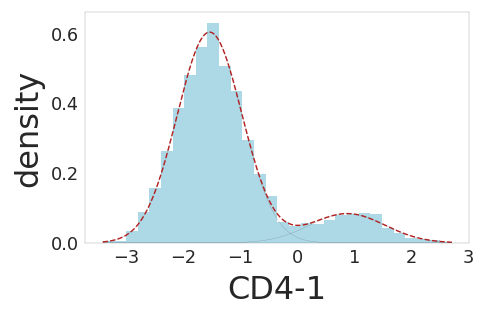

In [7]:
plot_keymarker(data,traversal,node_ID=2,dpi=128)

In [28]:
from scipy.stats import multivariate_normal, norm
import numpy as np

def assign_GMM(sample, mean_list, cov_list, weight, if_log=False, marker_list=None):
    # print(cov_list)
    index = sample.index
    # sample = np.array(sample)
    weight = np.array(weight)
    if if_log:
        type_num = np.log(weight/sum(weight))
    else:
        type_num = weight/sum(weight)
    
    p_prior = np.zeros(shape=(len(sample),len(weight)))
    for i in range(len(weight)):
        if if_log:
            # print(i)
            p_prior[:,i] = multivariate_normal.logpdf(np.array(sample.loc[:,marker_list]), mean=np.array(mean_list[i][marker_list]), cov=np.array(cov_list[i].loc[marker_list,marker_list]),allow_singular=True)
            p_prior[:,i] = p_prior[:,i] + type_num[i]
            
        else:
            
            # print([cov_list[i][j,j] for j in range(len(cov_list[i]))])
            # print(sample.loc[:,marker_list[i]])
            # print(mean_list[i])
            # print(cov_list[i])
            p_prior[:,i] = multivariate_normal.pdf(np.array(sample.loc[:,marker_list[i]]), mean=np.array(mean_list[i]), cov=np.array(cov_list[i]))   
            p_prior[:,i] = p_prior[:,i] * type_num[i]
    # p_prior = -p_prior 
    
    p_post = p_prior / (p_prior.sum(axis=1)[:,np.newaxis] )
    pred_label = np.argmin(p_post,axis=1)
    # print(p_prior[:10,:])
    # print(pred_label[:10])
    pred_label = pd.Series(data=pred_label,index=index)
    return pred_label

In [22]:
leaf_list = traversal.nodelist.copy()
leaf_list.pop(0)
leaf_list.pop(0)
leaf_list.pop(1)

In [31]:
node = traversal.get_node(3)
mean_list = [node.mean for node in leaf_list] 
cov_list = [node.cov for node in leaf_list]
w_list = [node.weight for node in leaf_list]
simulator = pd.read_csv('../simulator/ADT_simulator_9_10.csv', sep=',', index_col=0, header=0)
raw_label = assign_GMM(simulator, mean_list, cov_list, w_list, if_log=True,marker_list=['CD4-1','CD19','CD16','CD8'])
add_label = assign_GMM(simulator, mean_list, cov_list, w_list, if_log=True,marker_list=['CD4-1','CD19','CD16','CD8','CD3-1'])
#### 尝试用所有cutof<0.5的feature来assign，相当于是一个高维的gate

<AxesSubplot:>

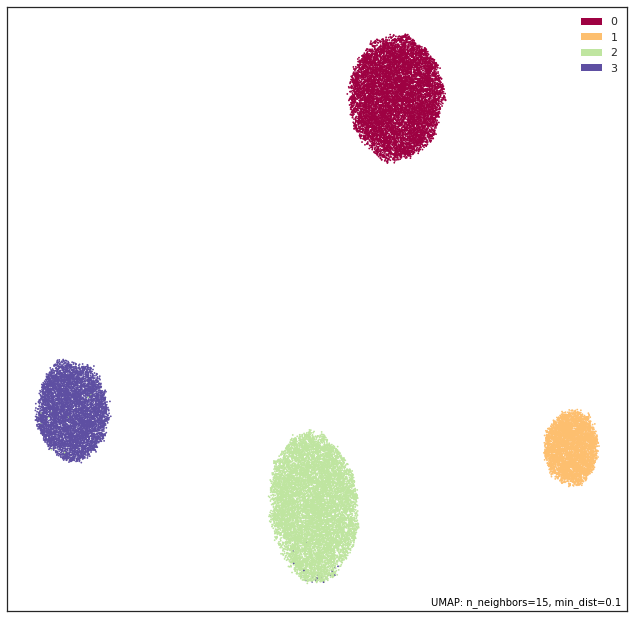

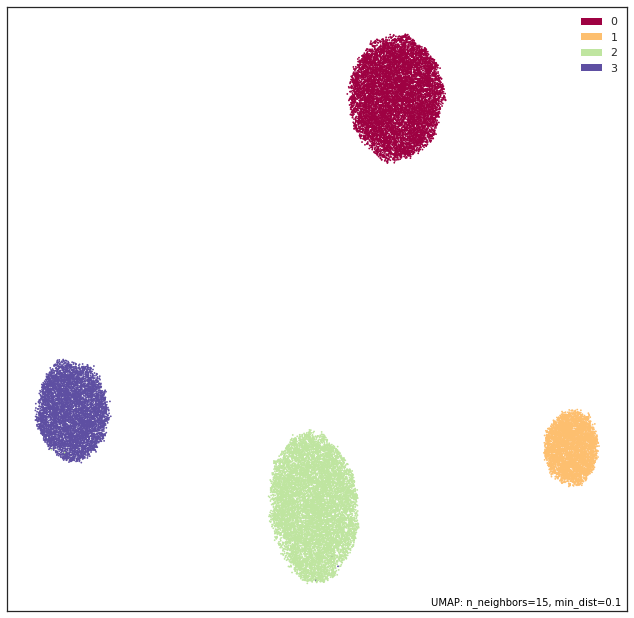

In [32]:
import umap
import umap.plot
import matplotlib.pyplot as plt

mapper = umap.UMAP().fit(simulator)
umap.plot.points(mapper, labels=raw_label)
umap.plot.points(mapper, labels=add_label)

In [36]:
raw_label.iloc[20675:].value_counts()
# add_label.iloc[20675:].value_counts()

2    9851
3      21
dtype: int64

In [46]:
# add_label.index = simulator.index
simulator[raw_label==3].to_csv('../simulator/ADT_simulator_9_11.csv')

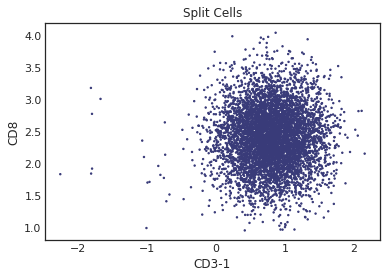

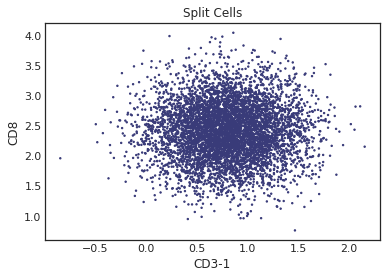

In [52]:
from CITEsort.Visualize import visualize_2dim

visualize_2dim(simulator[raw_label==3]['CD3-1'],simulator[raw_label==3]['CD8'],raw_label[raw_label==3])
visualize_2dim(simulator[add_label==3]['CD3-1'],simulator[add_label==3]['CD8'],add_label[add_label==3])

In [17]:
keys = []
for i in range(28):
    node = traversal.get_node(i)
    if list(node.key) != 'leaf':
        print(node.key)

('CD26-1',)
('IgD',)
('CD26-1',)
('leaf',)
('CD72',)
('CD4-1',)
('CD4-1',)
('CD27', 'CD8a')
('CD8a',)
('leaf',)
('CD244',)
('CD4-1',)
('leaf',)
('CD27',)
('leaf',)
('leaf',)
('leaf',)
('leaf',)
('CD244',)
('leaf',)
('leaf',)
('CD158', 'CD21')
('CD3-1',)
('leaf',)
('leaf',)
('leaf',)
('leaf',)
('leaf',)


In [15]:
'IgD',
'CD26-1',
'CD72',
'CD4-1',
'CD27', 'CD8a
'CD8a',
'CD244',
'CD4-1',
'CD27',
'CD244',
'CD158', 'CD21',
'CD3-1'

TypeError: unhashable type: 'list'